## Analysis

In [72]:
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import sklearn.metrics as skm

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

###### Load data and initalize variables

In [73]:
trainDf = spark.read.parquet(".data/trainDf.parquet")
validDf = spark.read.parquet(".data/validDf.parquet")

depVars = [
  'student_duration_mins',
  'timeliness_duration_mins',
  'item_attempt_duration_mins',
  'item_type_code_name_swoe',
  'number_of_distinct_instance_items'
]

###### Create regression dataframe
 - completed items
 - study variables
  - target
  - student_duration_mins
  - timeliness_duration_mins
  - item_attempt_duration_mins
  - item_type_code_name_swoe
  - number_of_distinct_instance_items

In [74]:
trnDf = trainDf.select('target',*depVars).toPandas()
valDf = validDf.select('target',*depVars).toPandas()

###### Target variable barplot

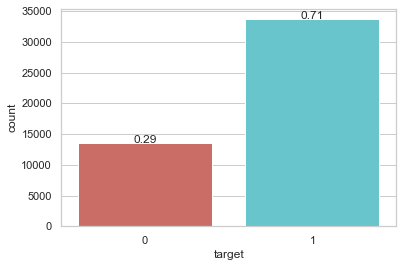

In [75]:
ax = sns.countplot(x='target',data=trnDf, palette='hls')
total = float(len(trnDf))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 
plt.show()

###### Train

In [76]:
y_train = trnDf['target']
X_train = trnDf[studyVars]

logreg = sm.Logit(y_train, X_train).fit()

print(logreg.summary())

Optimization terminated successfully.
         Current function value: 0.565841
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                47201
Model:                          Logit   Df Residuals:                    47196
Method:                           MLE   Df Model:                            4
Date:                Sun, 15 Nov 2020   Pseudo R-squ.:                 0.05524
Time:                        07:17:11   Log-Likelihood:                -26708.
converged:                       True   LL-Null:                       -28270.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
student_duration_mins                 0.0007      0.000      5

In [79]:
logreg.params

student_duration_mins                0.000702
timeliness_duration_mins             0.000002
item_attempt_duration_mins          -0.007457
item_type_code_name_swoe             0.883118
number_of_distinct_instance_items    0.005944
dtype: float64

###### Validate

In [77]:
y_valid = trnDf['target']
X_valid = trnDf[studyVars]

yhat = logreg.predict(X_valid)
prediction = list(map(round, yhat))

###### Reciever Operating Characteristic (ROC) Curve

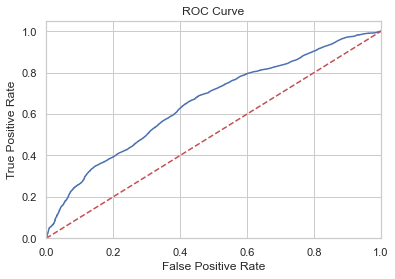

AUC of the model is: 0.7


In [78]:
# Calculate TP and FP
fpr, tpr, thresholds = skm.roc_curve(y_valid, yhat)

# Create ROC Plot
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate AUC
roc_auc = round(skm.auc(fpr, tpr), 1)
print("AUC of the model is:", roc_auc)

The area under curve (AUC) is .7. With a perfect AUC as 1, this means the model calculates true positives 70% of the time. Twenty percent better than at random.